# Research: Boston Marathon Cutoff Times
In this notebook we are going to explore how "fair" the boston marathon cutoff times are.  For each age bracket in the cutoffs, we will examine where the cutoff time lands within the distribution of the runner finish times, overall and for recent history.

In [1]:
import pandas as pd

BOSTON_MARATHON_CUTOFF_FILE = "../data/boston_marathon_qualifying.csv"
RACE_DATA = "../data/featurized_race_data_v2.csv"

In [2]:
# Load the data
bq_cutoffs = pd.read_csv(BOSTON_MARATHON_CUTOFF_FILE)
race_data = pd.read_csv(RACE_DATA)

# Filter to valid sex values and non-null ages
race_data = race_data[race_data['sex'].isin(['M', 'F'])]
race_data = race_data[race_data['age'].notna()]
race_data = race_data[race_data['time'].notna()]

print("BQ Cutoffs:")
display(bq_cutoffs)
print(f"\nRace data: {len(race_data):,} runners with valid age, sex, and time")

BQ Cutoffs:


,min_age,max_age,men_standard,women_standard,nonbinary_standard,men_standard_minutes,women_standard_minutes,nonbinary_standard_minutes
0,18,34.0,2:55:00,3:25:00,3:25:00,175,205,205
1,35,39.0,3:00:00,3:30:00,3:30:00,180,210,210
2,40,44.0,3:05:00,3:35:00,3:35:00,185,215,215
3,45,49.0,3:15:00,3:45:00,3:45:00,195,225,225
4,50,54.0,3:20:00,3:50:00,3:50:00,200,230,230
5,55,59.0,3:30:00,4:00:00,4:00:00,210,240,240
6,60,64.0,3:50:00,4:20:00,4:20:00,230,260,260
7,65,69.0,4:05:00,4:35:00,4:35:00,245,275,275
8,70,74.0,4:20:00,4:50:00,4:50:00,260,290,290
9,75,79.0,4:35:00,5:05:00,5:05:00,275,305,305



Race data: 1,357,437 runners with valid age, sex, and time


In [3]:
# Prepare date filtering
race_data['date'] = pd.to_datetime(race_data['date'])
max_date = race_data['date'].max()
print(f"Data date range: {race_data['date'].min()} to {max_date}")

# Create different time period datasets
race_data_all = race_data.copy()
race_data_3yr = race_data[race_data['date'] >= (max_date - pd.DateOffset(years=3))].copy()
race_data_5yr = race_data[race_data['date'] >= (max_date - pd.DateOffset(years=5))].copy()

print(f"\nAll time: {len(race_data_all):,} runners")
print(f"Past 3 years: {len(race_data_3yr):,} runners")
print(f"Past 5 years: {len(race_data_5yr):,} runners")

Data date range: 2000-01-08 00:00:00 to 2023-12-30 00:00:00

All time: 1,357,437 runners
Past 3 years: 129,227 runners
Past 5 years: 189,513 runners


In [4]:
# Function to assign runners to age brackets matching BQ cutoffs
def assign_age_bracket(age):
    """Assign age to BQ age bracket"""
    if pd.isna(age):
        return None
    age = int(age)
    if age < 18:
        return None
    elif age <= 34:
        return '18-34'
    elif age <= 39:
        return '35-39'
    elif age <= 44:
        return '40-44'
    elif age <= 49:
        return '45-49'
    elif age <= 54:
        return '50-54'
    elif age <= 59:
        return '55-59'
    elif age <= 64:
        return '60-64'
    elif age <= 69:
        return '65-69'
    elif age <= 74:
        return '70-74'
    elif age <= 79:
        return '75-79'
    else:
        return '80+'

# Apply to all datasets
for df in [race_data_all, race_data_3yr, race_data_5yr]:
    df['age_bracket'] = df['age'].apply(assign_age_bracket)
    
# Create lookup dict for BQ cutoffs
bq_cutoff_dict = {}
for _, row in bq_cutoffs.iterrows():
    min_age = int(row['min_age'])
    max_age = row['max_age']
    
    # Determine bracket label
    if pd.isna(max_age):
        bracket = '80+'
    else:
        max_age = int(max_age)
        bracket = f"{min_age}-{max_age}"
    
    bq_cutoff_dict[bracket] = {
        'men': row['men_standard_minutes'],
        'women': row['women_standard_minutes']
    }

print("BQ Cutoff Dictionary:")
for bracket, cutoffs in bq_cutoff_dict.items():
    print(f"{bracket}: Men={cutoffs['men']} min, Women={cutoffs['women']} min")

BQ Cutoff Dictionary:
18-34: Men=175 min, Women=205 min
35-39: Men=180 min, Women=210 min
40-44: Men=185 min, Women=215 min
45-49: Men=195 min, Women=225 min
50-54: Men=200 min, Women=230 min
55-59: Men=210 min, Women=240 min
60-64: Men=230 min, Women=260 min
65-69: Men=245 min, Women=275 min
70-74: Men=260 min, Women=290 min
75-79: Men=275 min, Women=305 min
80+: Men=290 min, Women=320 min


In [5]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Set up plotting style
plt.style.use('default')
%matplotlib inline

## Men's Age Bracket Analysis

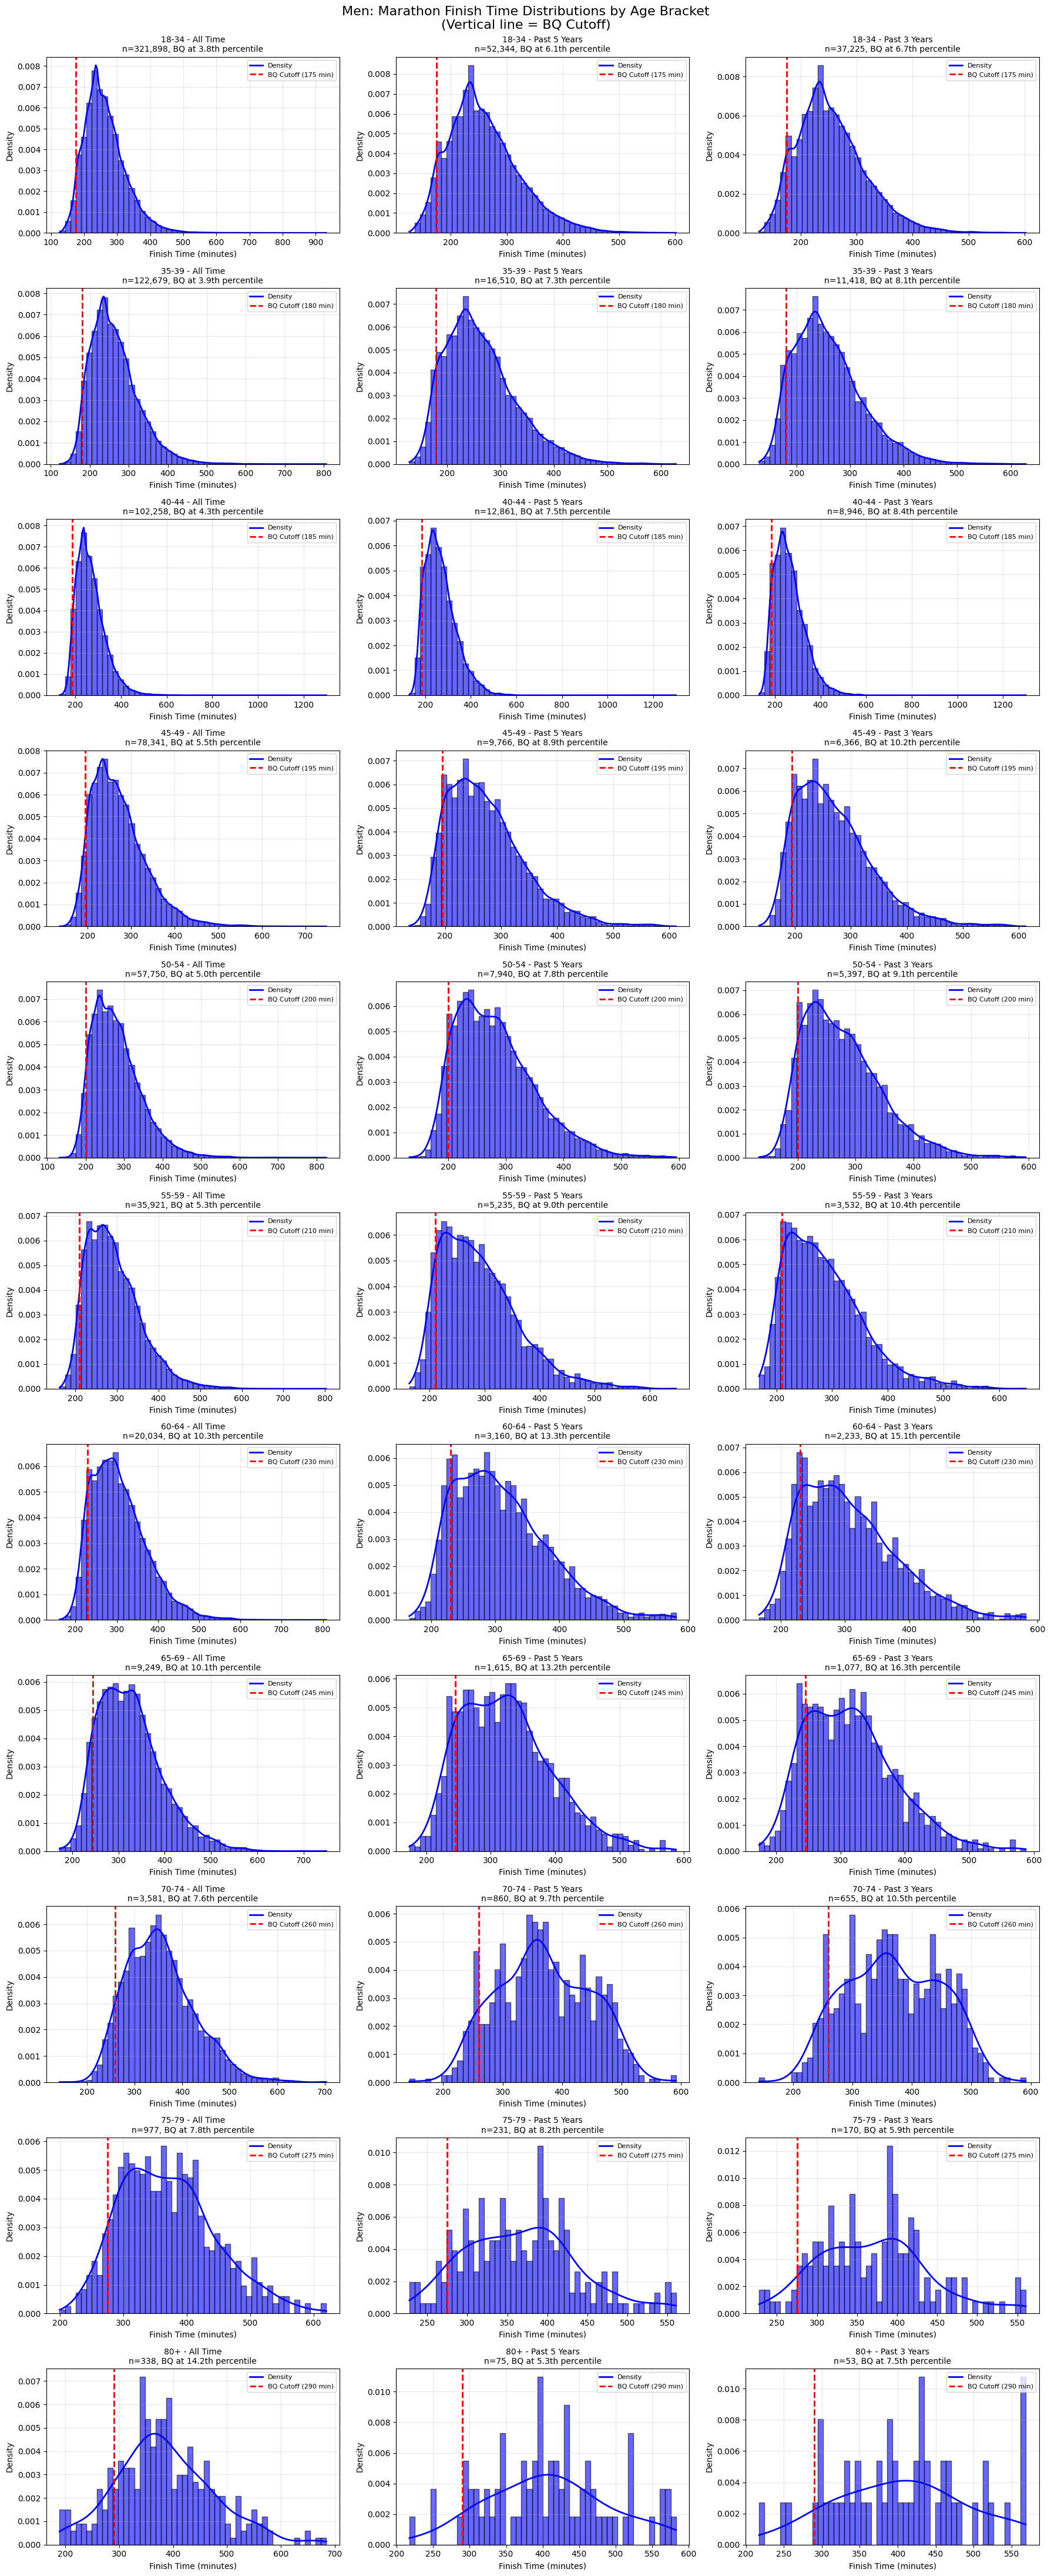

In [6]:
# Plot distributions for MEN across all age brackets
age_brackets = ['18-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80+']
datasets = {
    'All Time': race_data_all,
    'Past 5 Years': race_data_5yr,
    'Past 3 Years': race_data_3yr
}

fig, axes = plt.subplots(len(age_brackets), 3, figsize=(18, 4 * len(age_brackets)))
fig.suptitle('Men: Marathon Finish Time Distributions by Age Bracket\n(Vertical line = BQ Cutoff)', fontsize=16, y=0.995)

for i, bracket in enumerate(age_brackets):
    bq_cutoff = bq_cutoff_dict[bracket]['men']
    
    for j, (period, data) in enumerate(datasets.items()):
        ax = axes[i, j]
        
        # Filter data for this bracket and sex
        bracket_data = data[(data['age_bracket'] == bracket) & (data['sex'] == 'M')]['time'].dropna()
        
        if len(bracket_data) > 10:
            # Create histogram/KDE
            ax.hist(bracket_data, bins=50, density=True, alpha=0.6, color='blue', edgecolor='black')
            
            # Add KDE
            kde = stats.gaussian_kde(bracket_data)
            x_range = np.linspace(bracket_data.min(), bracket_data.max(), 200)
            ax.plot(x_range, kde(x_range), 'b-', linewidth=2, label='Density')
            
            # Add BQ cutoff line
            ax.axvline(bq_cutoff, color='red', linestyle='--', linewidth=2, label=f'BQ Cutoff ({bq_cutoff} min)')
            
            # Calculate percentile
            percentile = (bracket_data <= bq_cutoff).sum() / len(bracket_data) * 100
            
            # Add statistics
            ax.set_title(f'{bracket} - {period}\nn={len(bracket_data):,}, BQ at {percentile:.1f}th percentile', fontsize=10)
            ax.set_xlabel('Finish Time (minutes)')
            ax.set_ylabel('Density')
            ax.legend(fontsize=8)
            ax.grid(True, alpha=0.3)
        else:
            ax.text(0.5, 0.5, f'Insufficient data\n(n={len(bracket_data)})', 
                   ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f'{bracket} - {period}')

plt.tight_layout()
plt.show()

## Women's Age Bracket Analysis

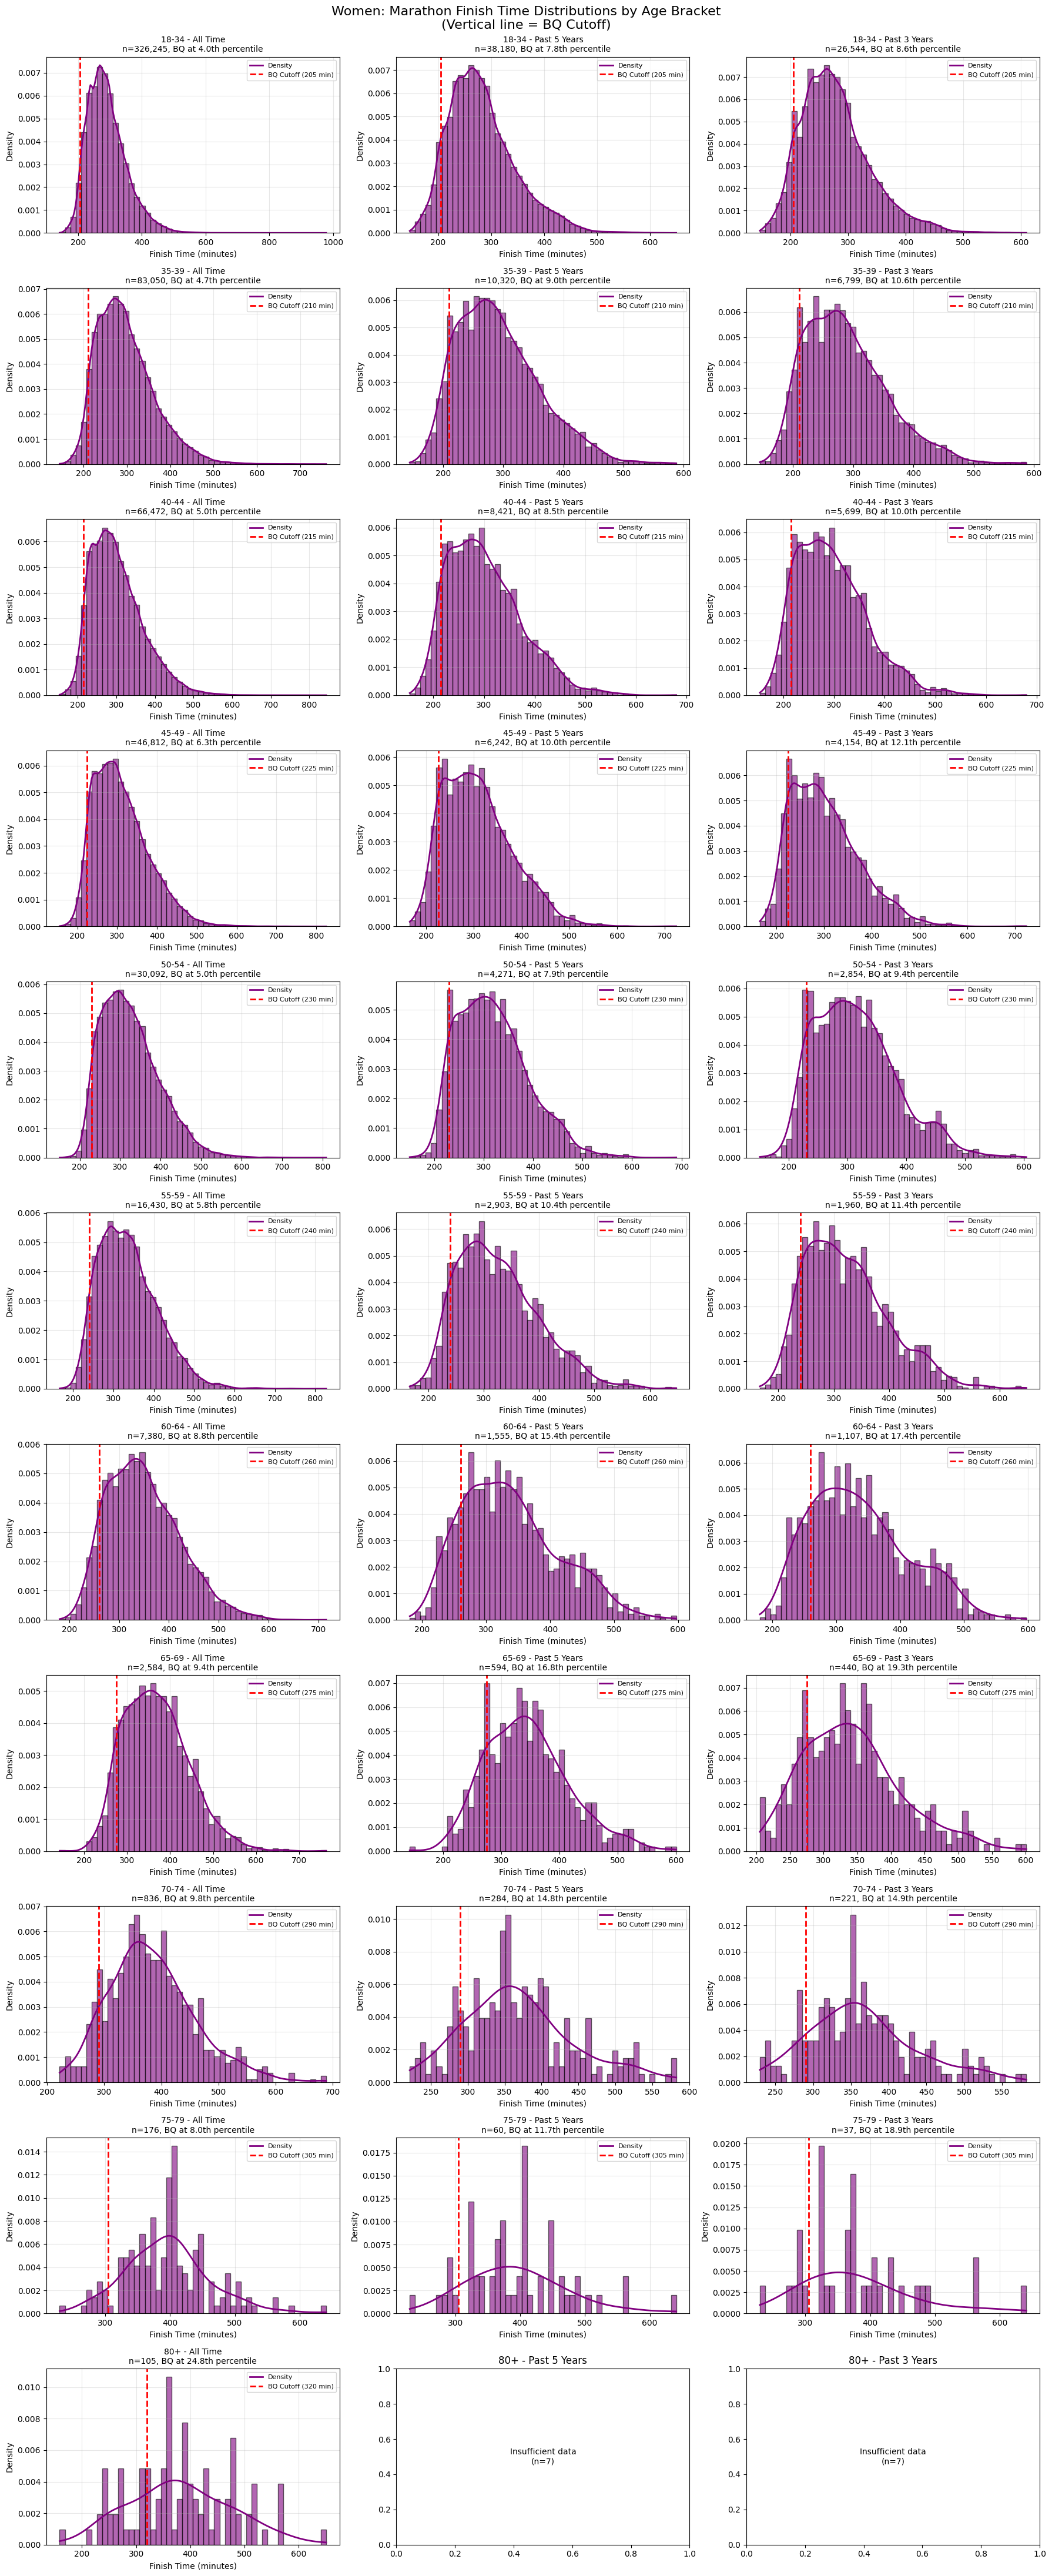

In [7]:
# Plot distributions for WOMEN across all age brackets
fig, axes = plt.subplots(len(age_brackets), 3, figsize=(18, 4 * len(age_brackets)))
fig.suptitle('Women: Marathon Finish Time Distributions by Age Bracket\n(Vertical line = BQ Cutoff)', fontsize=16, y=0.995)

for i, bracket in enumerate(age_brackets):
    bq_cutoff = bq_cutoff_dict[bracket]['women']
    
    for j, (period, data) in enumerate(datasets.items()):
        ax = axes[i, j]
        
        # Filter data for this bracket and sex
        bracket_data = data[(data['age_bracket'] == bracket) & (data['sex'] == 'F')]['time'].dropna()
        
        if len(bracket_data) > 10:
            # Create histogram/KDE
            ax.hist(bracket_data, bins=50, density=True, alpha=0.6, color='purple', edgecolor='black')
            
            # Add KDE
            kde = stats.gaussian_kde(bracket_data)
            x_range = np.linspace(bracket_data.min(), bracket_data.max(), 200)
            ax.plot(x_range, kde(x_range), 'purple', linewidth=2, label='Density')
            
            # Add BQ cutoff line
            ax.axvline(bq_cutoff, color='red', linestyle='--', linewidth=2, label=f'BQ Cutoff ({bq_cutoff} min)')
            
            # Calculate percentile
            percentile = (bracket_data <= bq_cutoff).sum() / len(bracket_data) * 100
            
            # Add statistics
            ax.set_title(f'{bracket} - {period}\nn={len(bracket_data):,}, BQ at {percentile:.1f}th percentile', fontsize=10)
            ax.set_xlabel('Finish Time (minutes)')
            ax.set_ylabel('Density')
            ax.legend(fontsize=8)
            ax.grid(True, alpha=0.3)
        else:
            ax.text(0.5, 0.5, f'Insufficient data\n(n={len(bracket_data)})', 
                   ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f'{bracket} - {period}')

plt.tight_layout()
plt.show()

## Summary: Percentile Analysis
This table shows at what percentile the BQ cutoff falls for each age bracket and sex. If the cutoffs were perfectly "fair" across age groups, these percentiles would all be similar.

In [13]:
# Calculate percentiles for all brackets, sexes, and time periods
# Including adjusted cutoff with 6:51 reduction
summary_data = []
CUTOFF_REDUCTION = 6 + 51/60  # 6 minutes 51 seconds = 6.85 minutes

for bracket in age_brackets:
    for sex, sex_label in [('M', 'Men'), ('F', 'Women')]:
        bq_cutoff = bq_cutoff_dict[bracket]['men' if sex == 'M' else 'women']
        bq_cutoff_adjusted = bq_cutoff - CUTOFF_REDUCTION
        
        row = {
            'age_bracket': bracket,
            'sex': sex_label,
            'bq_cutoff_minutes': bq_cutoff,
            'bq_adjusted_minutes': round(bq_cutoff_adjusted, 2)
        }
        
        for period_name, data in datasets.items():
            bracket_data = data[(data['age_bracket'] == bracket) & (data['sex'] == sex)]['time'].dropna()
            
            if len(bracket_data) > 10:
                # Original BQ cutoff percentile
                percentile = (bracket_data <= bq_cutoff).sum() / len(bracket_data) * 100
                row[f'{period_name}_percentile'] = round(percentile, 1)
                
                # Adjusted BQ cutoff percentile (with 6:51 reduction)
                percentile_adjusted = (bracket_data <= bq_cutoff_adjusted).sum() / len(bracket_data) * 100
                row[f'{period_name}_adjusted_pct'] = round(percentile_adjusted, 1)
                
                # Difference between standard and adjusted percentile
                row[f'{period_name}_pct_diff'] = round(percentile - percentile_adjusted, 1)
                
                row[f'{period_name}_count'] = len(bracket_data)
            else:
                row[f'{period_name}_percentile'] = None
                row[f'{period_name}_adjusted_pct'] = None
                row[f'{period_name}_pct_diff'] = None
                row[f'{period_name}_count'] = len(bracket_data)
        
        summary_data.append(row)

summary_df = pd.DataFrame(summary_data)

# Split into separate tables for men and women
men_df = summary_df[summary_df['sex'] == 'Men'].drop(columns=['sex']).reset_index(drop=True)
women_df = summary_df[summary_df['sex'] == 'Women'].drop(columns=['sex']).reset_index(drop=True)

print("BQ Cutoff Percentile Analysis - MEN")
print("Standard cutoff vs. 6:51 faster required cutoff")
print("="*120)
print(f"\nNote: 'adjusted_pct' columns show percentiles with {CUTOFF_REDUCTION:.2f} minute reduction (6:51)")
print("      'pct_diff' columns show the percentile point difference (impact of the 6:51 buffer)")
display(men_df)

print("\n\n")
print("BQ Cutoff Percentile Analysis - WOMEN")
print("Standard cutoff vs. 6:51 faster required cutoff")
print("="*120)
print(f"\nNote: 'adjusted_pct' columns show percentiles with {CUTOFF_REDUCTION:.2f} minute reduction (6:51)")
print("      'pct_diff' columns show the percentile point difference (impact of the 6:51 buffer)")
display(women_df)

BQ Cutoff Percentile Analysis - MEN
Standard cutoff vs. 6:51 faster required cutoff

Note: 'adjusted_pct' columns show percentiles with 6.85 minute reduction (6:51)
      'pct_diff' columns show the percentile point difference (impact of the 6:51 buffer)


,age_bracket,bq_cutoff_minutes,bq_adjusted_minutes,All Time_percentile,All Time_adjusted_pct,All Time_pct_diff,All Time_count,Past 5 Years_percentile,Past 5 Years_adjusted_pct,Past 5 Years_pct_diff,Past 5 Years_count,Past 3 Years_percentile,Past 3 Years_adjusted_pct,Past 3 Years_pct_diff,Past 3 Years_count
0,18-34,175,168.15,3.8,2.3,1.4,321898,6.1,3.8,2.3,52344,6.7,4.1,2.5,37225
1,35-39,180,173.15,3.9,2.0,1.9,122679,7.3,3.9,3.4,16510,8.1,4.4,3.7,11418
2,40-44,185,178.15,4.3,2.4,2.0,102258,7.5,4.1,3.4,12861,8.4,4.8,3.6,8946
3,45-49,195,188.15,5.5,3.2,2.2,78341,8.9,5.5,3.4,9766,10.2,6.3,3.9,6366
4,50-54,200,193.15,5.0,2.9,2.1,57750,7.8,4.6,3.2,7940,9.1,5.4,3.6,5397
5,55-59,210,203.15,5.3,3.0,2.3,35921,9.0,5.3,3.8,5235,10.4,6.2,4.2,3532
6,60-64,230,223.15,10.3,6.6,3.6,20034,13.3,8.6,4.7,3160,15.1,9.8,5.3,2233
7,65-69,245,238.15,10.1,7.0,3.1,9249,13.2,9.5,3.7,1615,16.3,12.0,4.4,1077
8,70-74,260,253.15,7.6,5.4,2.2,3581,9.7,6.4,3.3,860,10.5,6.9,3.7,655
9,75-79,275,268.15,7.8,5.6,2.1,977,8.2,6.5,1.7,231,5.9,4.7,1.2,170





BQ Cutoff Percentile Analysis - WOMEN
Standard cutoff vs. 6:51 faster required cutoff

Note: 'adjusted_pct' columns show percentiles with 6.85 minute reduction (6:51)
      'pct_diff' columns show the percentile point difference (impact of the 6:51 buffer)


,age_bracket,bq_cutoff_minutes,bq_adjusted_minutes,All Time_percentile,All Time_adjusted_pct,All Time_pct_diff,All Time_count,Past 5 Years_percentile,Past 5 Years_adjusted_pct,Past 5 Years_pct_diff,Past 5 Years_count,Past 3 Years_percentile,Past 3 Years_adjusted_pct,Past 3 Years_pct_diff,Past 3 Years_count
0,18-34,205,198.15,4.0,2.5,1.5,326245,7.8,5.2,2.6,38180,8.6,5.6,2.9,26544
1,35-39,210,203.15,4.7,2.9,1.8,83050,9.0,6.0,3.0,10320,10.6,7.1,3.5,6799
2,40-44,215,208.15,5.0,3.1,1.9,66472,8.5,5.7,2.8,8421,10.0,6.7,3.2,5699
3,45-49,225,218.15,6.3,3.9,2.4,46812,10.0,6.5,3.5,6242,12.1,7.9,4.3,4154
4,50-54,230,223.15,5.0,3.0,2.1,30092,7.9,4.7,3.3,4271,9.4,5.3,4.0,2854
5,55-59,240,233.15,5.8,3.7,2.1,16430,10.4,7.0,3.4,2903,11.4,8.0,3.4,1960
6,60-64,260,253.15,8.8,6.3,2.5,7380,15.4,12.2,3.2,1555,17.4,13.9,3.5,1107
7,65-69,275,268.15,9.4,6.7,2.7,2584,16.8,12.5,4.4,594,19.3,14.8,4.5,440
8,70-74,290,283.15,9.8,7.7,2.2,836,14.8,11.3,3.5,284,14.9,11.8,3.2,221
9,75-79,305,298.15,8.0,6.8,1.1,176,11.7,11.7,0.0,60,18.9,18.9,0.0,37


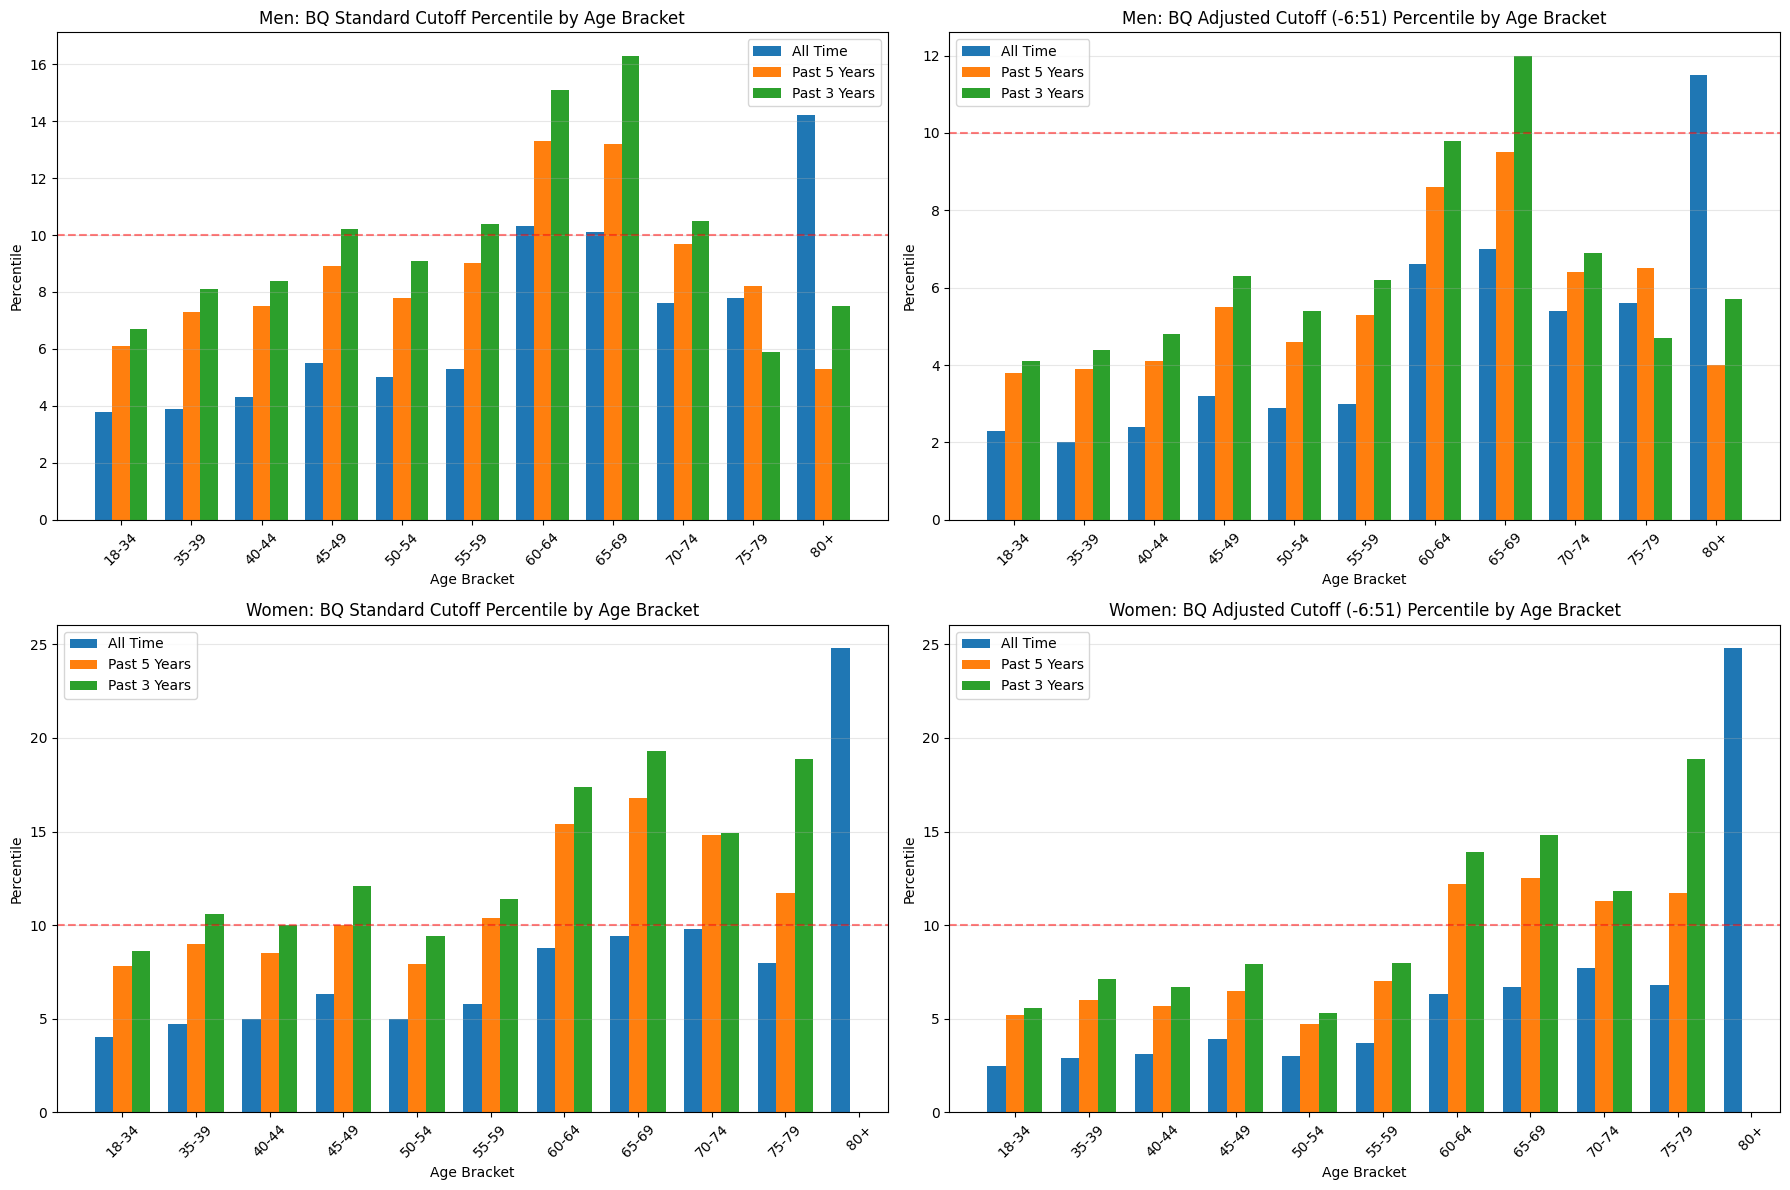

In [14]:
# Visualize percentile comparison across age brackets
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Men - Standard Cutoff
men_data = summary_df[summary_df['sex'] == 'Men'].copy()
x = np.arange(len(men_data))
width = 0.25

ax = axes[0, 0]
for i, period in enumerate(['All Time', 'Past 5 Years', 'Past 3 Years']):
    col = f'{period}_percentile'
    if col in men_data.columns:
        ax.bar(x + i*width, men_data[col], width, label=period)

ax.set_xlabel('Age Bracket')
ax.set_ylabel('Percentile')
ax.set_title('Men: BQ Standard Cutoff Percentile by Age Bracket')
ax.set_xticks(x + width)
ax.set_xticklabels(men_data['age_bracket'], rotation=45)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
ax.axhline(y=10, color='red', linestyle='--', alpha=0.5)

# Men - Adjusted Cutoff (6:51 faster)
ax = axes[0, 1]
for i, period in enumerate(['All Time', 'Past 5 Years', 'Past 3 Years']):
    col = f'{period}_adjusted_pct'
    if col in men_data.columns:
        ax.bar(x + i*width, men_data[col], width, label=period)

ax.set_xlabel('Age Bracket')
ax.set_ylabel('Percentile')
ax.set_title('Men: BQ Adjusted Cutoff (-6:51) Percentile by Age Bracket')
ax.set_xticks(x + width)
ax.set_xticklabels(men_data['age_bracket'], rotation=45)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
ax.axhline(y=10, color='red', linestyle='--', alpha=0.5)

# Women - Standard Cutoff
women_data = summary_df[summary_df['sex'] == 'Women'].copy()

ax = axes[1, 0]
for i, period in enumerate(['All Time', 'Past 5 Years', 'Past 3 Years']):
    col = f'{period}_percentile'
    if col in women_data.columns:
        ax.bar(x + i*width, women_data[col], width, label=period)

ax.set_xlabel('Age Bracket')
ax.set_ylabel('Percentile')
ax.set_title('Women: BQ Standard Cutoff Percentile by Age Bracket')
ax.set_xticks(x + width)
ax.set_xticklabels(women_data['age_bracket'], rotation=45)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
ax.axhline(y=10, color='red', linestyle='--', alpha=0.5)

# Women - Adjusted Cutoff (6:51 faster)
ax = axes[1, 1]
for i, period in enumerate(['All Time', 'Past 5 Years', 'Past 3 Years']):
    col = f'{period}_adjusted_pct'
    if col in women_data.columns:
        ax.bar(x + i*width, women_data[col], width, label=period)

ax.set_xlabel('Age Bracket')
ax.set_ylabel('Percentile')
ax.set_title('Women: BQ Adjusted Cutoff (-6:51) Percentile by Age Bracket')
ax.set_xticks(x + width)
ax.set_xticklabels(women_data['age_bracket'], rotation=45)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
ax.axhline(y=10, color='red', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

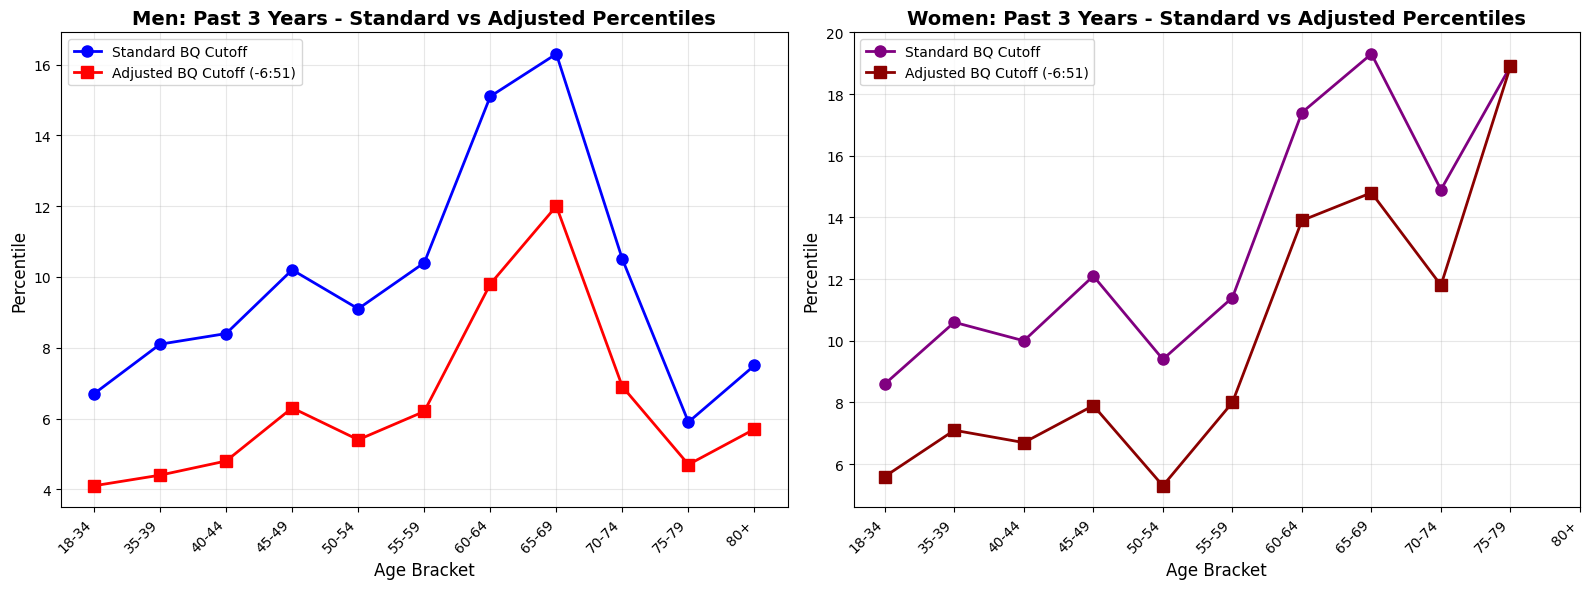

In [15]:
# Plot Past 3 Years: Standard vs Adjusted Percentiles
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Men
men_data = summary_df[summary_df['sex'] == 'Men'].copy()
x = np.arange(len(men_data))

ax1.plot(x, men_data['Past 3 Years_percentile'], marker='o', linewidth=2, markersize=8, 
         label='Standard BQ Cutoff', color='blue')
ax1.plot(x, men_data['Past 3 Years_adjusted_pct'], marker='s', linewidth=2, markersize=8, 
         label='Adjusted BQ Cutoff (-6:51)', color='red')

ax1.set_xlabel('Age Bracket', fontsize=12)
ax1.set_ylabel('Percentile', fontsize=12)
ax1.set_title('Men: Past 3 Years - Standard vs Adjusted Percentiles', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(men_data['age_bracket'], rotation=45, ha='right')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Women
women_data = summary_df[summary_df['sex'] == 'Women'].copy()

ax2.plot(x, women_data['Past 3 Years_percentile'], marker='o', linewidth=2, markersize=8, 
         label='Standard BQ Cutoff', color='purple')
ax2.plot(x, women_data['Past 3 Years_adjusted_pct'], marker='s', linewidth=2, markersize=8, 
         label='Adjusted BQ Cutoff (-6:51)', color='darkred')

ax2.set_xlabel('Age Bracket', fontsize=12)
ax2.set_ylabel('Percentile', fontsize=12)
ax2.set_title('Women: Past 3 Years - Standard vs Adjusted Percentiles', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(women_data['age_bracket'], rotation=45, ha='right')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Key Findings

The analysis above reveals how "fair" the Boston Marathon qualifying standards are across different age brackets:

1. **Consistency Check**: If the BQ cutoffs were perfectly calibrated across age groups, they should land at similar percentiles for all age brackets. Variations indicate some age groups may have it easier or harder to qualify.

2. **Time Period Comparison**: Comparing all-time data vs recent years (3-year and 5-year windows) shows whether the general population of marathon runners is getting faster or slower, and whether the BQ standards are keeping pace.

3. **Gender Differences**: Comparing the percentile distributions between men and women reveals whether the standards are equally challenging across genders.

4. **Adjusted Cutoff Analysis (6:51 reduction)**: The Boston Athletic Association (BAA) often requires runners to beat their qualifying time by several minutes to actually gain entry due to high demand. The 6:51 reduction represents a recent cutoff buffer, showing what percentile of runners would actually make it into the race.

Look for:
- **Age brackets where the cutoff is at a lower percentile**: These groups may have it "easier" to qualify
- **Age brackets where the cutoff is at a higher percentile**: These groups may have it "harder" to qualify
- **Trends over time**: Are recent runners faster or slower than historical averages?
- **Impact of the 6:51 buffer**: How much harder does this additional requirement make it to actually get into Boston?